### Imports

In [1]:
# Imports and set up
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from torcheeg.io.eeg_signal import EEGSignalIO
from sklearn.model_selection import train_test_split
from einops import rearrange

## Path to dir with data (remember the last '/')
path = "../data/"

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(path), io_mode='lmdb')
## Read metadata dataframeimports
metadata = pd.read_csv(path + 'sample_metadata.tsv', sep='\t')

### Load data

In [3]:
# Verifying connextion to data
idxs = np.arange(len(metadata))

X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
print(f"nsamples: {X.shape[0]}  -  nchannels: {X.shape[1]}  -  t: {X.shape[2]}")

y = torch.tensor(metadata["value"].values, dtype=torch.long)

nsamples: 5184  -  nchannels: 22  -  t: 800


### Split data into train, validation and test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"shape of X train: {X_train.shape}")
print(f"shape of X val: {X_val.shape}")
print(f"shape of X test: {X_test.shape}")

print(f"shape of y train: {y_train.shape}")
print(f"shape of y val: {y_val.shape}")
print(f"shape of y test: {y_test.shape}")

shape of X train: torch.Size([3110, 22, 800])
shape of X val: torch.Size([1037, 22, 800])
shape of X test: torch.Size([1037, 22, 800])
shape of y train: torch.Size([3110])
shape of y val: torch.Size([1037])
shape of y test: torch.Size([1037])


In [5]:
#set up of matrixies 
#number of samples, channels, and timesteps
nsamples_train, nchannels_train, t = X_train.shape
nsamples_val, nchannels_val, t = X_val.shape

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

adj_matrix_train = torch.eye(nchannels_train)
adj_matrix_val = torch.eye(nchannels_val)

In [6]:
print(adj_matrix_train.shape)
print(type(adj_matrix_train))
print(nsamples_train)

print(adj_matrix_val.shape)
print(type(adj_matrix_val))
print(nsamples_val)

torch.Size([22, 22])
<class 'torch.Tensor'>
3110
torch.Size([22, 22])
<class 'torch.Tensor'>
1037


### Model training definition

In [7]:
class TrainNN():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_loader, val_loader, learning_rate, epochs=100, prints=True):
        model = model.to(self.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        highest_train_accuracy = 0.0
        
        losses_train = []; losses_val = []

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0; running_loss_val = 0.0
            correct = 0; correct_val = 0
            total = 0; total_val = 0
            
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct/total
            losses_train.append(epoch_loss)
            
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss_val += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
            epoch_loss_val = running_loss_val / len(val_loader.dataset)
            epoch_accuracy_val = correct_val/total_val
            losses_val.append(epoch_loss_val)
                
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy

            if prints:
                print(f"Epoch {epoch+1}/{epochs}, Train loss: {epoch_loss:.4f}, Train acc: {(epoch_accuracy*100):.2f}%" +
                     f"| Val loss: {epoch_loss_val:.4f}, Val acc: {(epoch_accuracy_val*100):.2f}%")

        print(f"Highest Train Accuracy {(highest_train_accuracy*100):.2f}")
        torch.save(model.state_dict(), 'eeg_gnn.pth')
        
        losses = [losses_train, losses_val]

        return model, losses

### Model architecture

In [8]:
class CollapsedShallowNet(nn.Module):
    """
    A version of the ShallowFBCSPNet model with a combined spatiotemporal convolution instead of separate temporal and spatial convolutions

    Args:
        n_chans (int): Number of input channels.
        n_outputs (int): Number of output classes.
        n_times (int, optional): Number of timepoints in the input.
        dropout (float, optional): Dropout probability. Defaults to 0.5.
        num_kernels (int, optional): Number of kernels in the spatiotemporal convolution. Defaults to 40.
        kernel_size (int, optional): Size of the kernel in the spatiotemporal convolution. Defaults to 25.
        pool_size (int, optional): Size of the pooling window in the spatiotemporal convolution. Default is 100.
    """

    def __init__(self, n_chans, n_outputs, n_times=1001, dropout=0.5, num_kernels=40, kernel_size=25, pool_size=100):
        super(CollapsedShallowNet, self).__init__()
        self.spatio_temporal = nn.Conv2d(
            n_chans, num_kernels, (1, kernel_size))
        self.pool = nn.AvgPool2d((1, pool_size))
        self.batch_norm = nn.BatchNorm2d(num_kernels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.LazyLinear(n_outputs)

    def forward(self, x):
        x = torch.unsqueeze(x, dim=2)
        x = self.spatio_temporal(x)
        x = F.elu(x)
        x = self.batch_norm(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


### Training & model hyperparameters

In [17]:
# Model parameters
n_chans = 22
n_outputs = y.max().item() + 1
n_times = 800
dropout = 0.6
n_kernels = 40
kernel_size = 25
pool_size = 100

# Training parameters
lr = 1e-3
epochs = 60

### Training

In [18]:
nclasses = y.max().item() + 1 
model = CollapsedShallowNet(n_chans, n_outputs, n_times=n_times, dropout=dropout, num_kernels=n_kernels,
                           kernel_size=kernel_size, pool_size=pool_size)

trainer = TrainNN()
trained_model, losses = trainer.train_model(model, train_loader, val_loader, learning_rate=lr, epochs=epochs, prints=True)

Epoch 1/60, Train loss: 1.5374, Train acc: 31.09%| Val loss: 1.4589, Val acc: 34.23%
Epoch 2/60, Train loss: 1.3773, Train acc: 38.26%| Val loss: 1.3297, Val acc: 37.13%
Epoch 3/60, Train loss: 1.2830, Train acc: 41.54%| Val loss: 1.2691, Val acc: 41.66%
Epoch 4/60, Train loss: 1.2394, Train acc: 43.73%| Val loss: 1.2492, Val acc: 42.43%
Epoch 5/60, Train loss: 1.2096, Train acc: 46.37%| Val loss: 1.2114, Val acc: 44.94%
Epoch 6/60, Train loss: 1.1784, Train acc: 47.56%| Val loss: 1.1966, Val acc: 44.17%
Epoch 7/60, Train loss: 1.1534, Train acc: 49.68%| Val loss: 1.1795, Val acc: 47.44%
Epoch 8/60, Train loss: 1.1355, Train acc: 49.23%| Val loss: 1.1734, Val acc: 47.35%
Epoch 9/60, Train loss: 1.1130, Train acc: 51.03%| Val loss: 1.1589, Val acc: 47.35%
Epoch 10/60, Train loss: 1.0958, Train acc: 51.80%| Val loss: 1.1584, Val acc: 46.38%
Epoch 11/60, Train loss: 1.0914, Train acc: 51.41%| Val loss: 1.1378, Val acc: 48.70%
Epoch 12/60, Train loss: 1.0766, Train acc: 53.79%| Val loss: 1

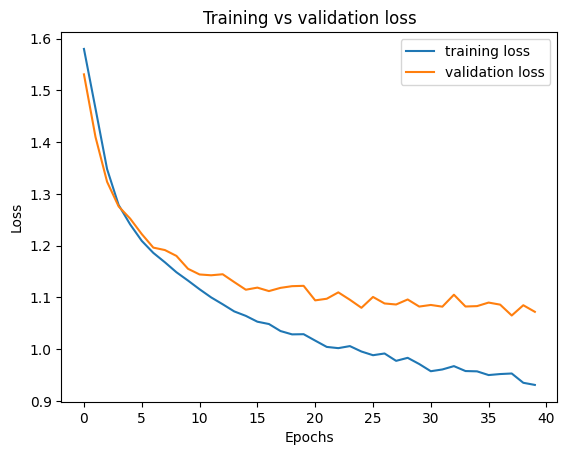

In [14]:
plt.plot(losses[0])
plt.plot(losses[1])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training loss","validation loss"])
plt.title("Training vs validation loss");